In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset')

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 1.16GB/s]

In [62]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


In [63]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [64]:
def load_data(data_dir):  # helper function to merge paths
    image_paths = []
    labels = []

    for label in os.listdir(data_dir):
        label_folder = os.path.join(data_dir, label)
        if os.path.isdir(label_folder):  # Check if it's a directory
            for image in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image)
                image_paths.append(image_path)
                labels.append(label)

    return shuffle(image_paths, labels, random_state=42)


In [65]:
# Paths of dataset
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

# Load training and testing data
train_paths, train_labels = load_data(train_dir)
test_paths, test_labels = load_data(test_dir)

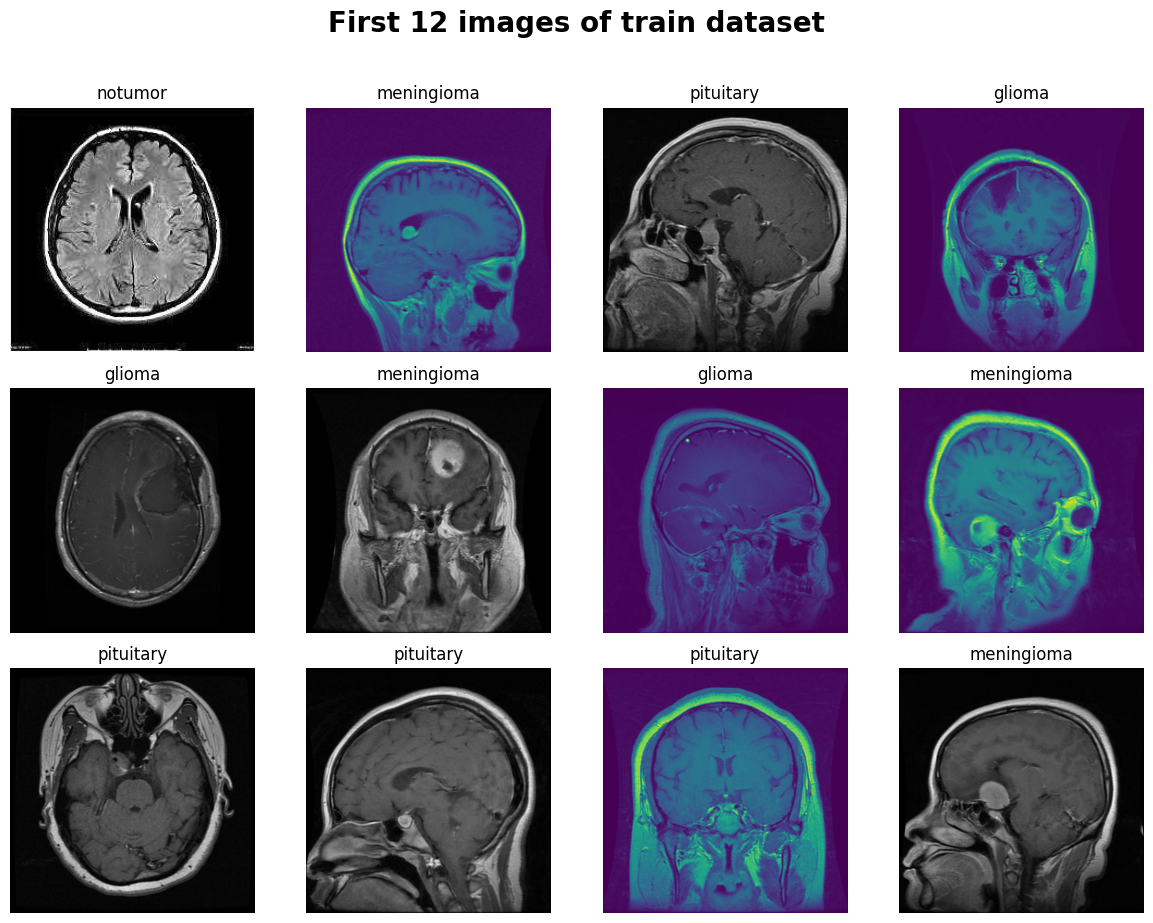

In [66]:

# Showing first 12 images from the dataset
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle("First 12 images of train dataset", fontsize=20, fontweight='bold', y=1.02)

for i, ax in enumerate(axes.flat):
    img = plt.imread(train_paths[i])
    ax.imshow(img)
    ax.set_title(train_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [67]:

# Label encoding (string → int)
label_to_index = {label: idx for idx, label in enumerate(sorted(set(train_labels)))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
print(f"Label mapping: {label_to_index}")

train_labels = [label_to_index[label] for label in train_labels]
test_labels = [label_to_index[label] for label in test_labels]

Label mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [68]:
# Custom augmentation (only for training)
class AugmentAndTransform:
    def __init__(self):
        self.resize_crop = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
        ])
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __call__(self, image):
        # Resize and crop
        image = self.resize_crop(image)

        # Random brightness and contrast (Augmentation)
        image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
        image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

        # To Tensor and Normalize
        image = self.to_tensor(image)
        return image

In [69]:
# For test set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [70]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Open and apply transform
        image = Image.open(path).convert("RGB")
        image = self.transform(image)

        return image, label


In [71]:
# Creating datasets and dataloaders
train_dataset = CustomDataset(train_paths, train_labels, transform=AugmentAndTransform())
test_dataset = CustomDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [72]:

# Loading VGG16 model
from torchvision.models import vgg16

vgg16_model = vgg16(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
# Cleariing  GPU cache before loading model
torch.cuda.empty_cache()


In [74]:

# Freeze feature extractor layers
for param in vgg16_model.features.parameters():
    param.requires_grad = False

# Unfreeze last few layers for fine-tuning
for param in vgg16_model.features[-3:].parameters():  # Unfreeze last 3 layers
    param.requires_grad = True


In [75]:

# Modifying classifier to match your original design
vgg16_model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),  # VGG16 feature size is 25088
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 4)  # 4 classes
)


In [76]:

# Move model to device
vgg16_model = vgg16_model.to(device)


In [77]:
# Training parameters
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=learning_rate)
epochs = 15


In [78]:

# Training loop with memory optimization
print("Starting training...")
for epoch in range(epochs):
    vgg16_model.train()
    total_epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (batch_features, batch_labels) in enumerate(train_loader):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward pass
        outputs = vgg16_model(batch_features)

        # Loss calculation
        loss = loss_fn(outputs, batch_labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += batch_labels.size(0)
        correct_predictions += (predicted == batch_labels).sum().item()

        # Clear cache periodically to prevent memory buildup
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()

    avg_loss = total_epoch_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%')

    # Clear cache after each epoch
    torch.cuda.empty_cache()

Starting training...
Epoch 1/15 - Loss: 0.7907 - Accuracy: 70.20%
Epoch 2/15 - Loss: 0.5673 - Accuracy: 80.20%
Epoch 3/15 - Loss: 0.5124 - Accuracy: 83.09%
Epoch 4/15 - Loss: 0.4806 - Accuracy: 84.66%
Epoch 5/15 - Loss: 0.4351 - Accuracy: 86.50%
Epoch 6/15 - Loss: 0.3845 - Accuracy: 87.66%
Epoch 7/15 - Loss: 0.3222 - Accuracy: 89.86%
Epoch 8/15 - Loss: 0.3457 - Accuracy: 90.84%
Epoch 9/15 - Loss: 0.2869 - Accuracy: 92.16%
Epoch 10/15 - Loss: 0.3161 - Accuracy: 91.63%
Epoch 11/15 - Loss: 0.2866 - Accuracy: 92.65%
Epoch 12/15 - Loss: 0.2290 - Accuracy: 93.89%
Epoch 13/15 - Loss: 0.2437 - Accuracy: 93.82%
Epoch 14/15 - Loss: 0.2733 - Accuracy: 93.56%
Epoch 15/15 - Loss: 0.2284 - Accuracy: 94.73%


# Evaluation time

# Evaluation on test data

In [83]:
import torch

print("\nEvaluating on test set...")

vgg16_model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0

all_preds = []   # To store all predicted labels
all_labels = []  # To store all true labels

with torch.no_grad():  # No need to compute gradients during evaluation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = vgg16_model(images)
        _, predicted = torch.max(outputs, 1)  # Pick the class with highest score

        # Update overall accuracy counts
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store predictions and true labels for plotting later
        all_preds.extend(predicted.cpu().numpy())      # Move to CPU and convert to NumPy
        all_labels.extend(labels.cpu().numpy())

# Calculate total accuracy
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")



Evaluating on test set...
Test Accuracy: 96.19%


# Evaluation on training data

In [85]:

# Evaluation on test set
print("\nEvaluating on test set...")
vgg16_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = vgg16_model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_labels.size(0)
        test_correct += (predicted == batch_labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Train Accuracy: {test_accuracy:.2f}%')



Evaluating on test set...
Train Accuracy: 99.26%


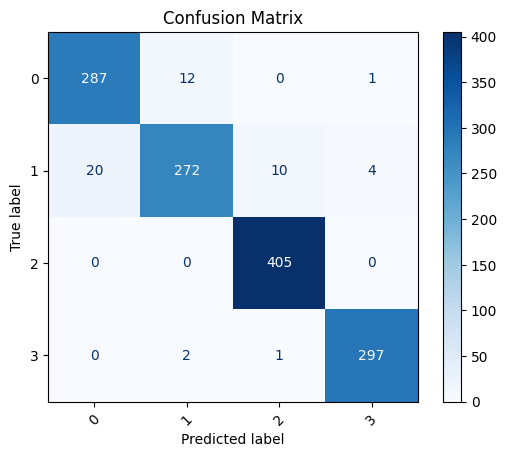

In [84]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [89]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       300
           1       0.95      0.89      0.92       306
           2       0.97      1.00      0.99       405
           3       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

